<a href="https://colab.research.google.com/github/guilhermelaviola/CustomerSegmentationModel/blob/main/CustomerChurnPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Pandas library, loading and displaying the dataset
import pandas as pd

df = pd.read_csv('data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# There are 8 different variables in the dataframe: InvoiceNo, StockCode,
# Description, Quantity, InvoiceDate, UnitPrice, CustomerID and Country
# With the transaction data, we need to build different customer segments
# based on each user purchase behavior

# Before taking any further step, we need to prepare the data
# The informative features in the dataset that tells us aboyt the customer
# buying behavior are Quantity, InvoiveDate and UnitPrice.
# With these variables we cab derive the customer's RFM (Recency, Frequency,
# Monetary Value) profile.
# These variables will be used to build a segmentation model.

# Calculating recency:
# Converting the date column into datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])

In [3]:
# Keeping the most recent date of purchase only
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min')
df_rec = df[df['rank'] == 1]

In [4]:
# Assigning a recency score ro each CustomerID.
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

<ipython-input-4-69b0b5db1d95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


In [5]:
# Now it's time to calculate the frequency, in other words, how many times each
# customer made a purchase on the platform
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID', 'frequency']

# The new dataframe that was just created contains two columns: 'CustomerID'
# and 'frequency'. Let's merge this dataframe with the previous one:
rec_freq = df_freq.merge(df_rec, on = 'CustomerID')

In [6]:
# Displaying the dataframe, for testing
rec_freq.head(10)

,CustomerID,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Date,rank,recency
0,12346.0,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,1/18/2011 10:01,1.04,United Kingdom,2011-01-18 10:01:00,1.0,48
1,12347.0,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12.0,12/7/2010 14:57,2.10,Iceland,2010-12-07 14:57:00,1.0,6
2,12347.0,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4.0,12/7/2010 14:57,4.25,Iceland,2010-12-07 14:57:00,1.0,6
3,12347.0,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12.0,12/7/2010 14:57,3.25,Iceland,2010-12-07 14:57:00,1.0,6
4,12347.0,31,537626,22492,MINI PAINT SET VINTAGE,36.0,12/7/2010 14:57,0.65,Iceland,2010-12-07 14:57:00,1.0,6
5,12347.0,31,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12.0,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
6,12347.0,31,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12.0,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
7,12347.0,31,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12.0,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
8,12347.0,31,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12.0,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
9,12347.0,31,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12.0,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6


In [7]:
# Calculating each user's monetary value (mv) to understand the total amount
# the customers have spent in the platform
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
mv = rec_freq.groupby('CustomerID')['total'].sum()
mv = pd.DataFrame(mv).reset_index()
mv.columns = ['CustomerID', 'monetary_value']

In [8]:
# The new dataframe taht was just created consists of each CustomerID and
# its associated monetary value.
# Merging it with the main dataframe
rfm = mv.merge(rec_freq, on = 'CustomerID')

# Displaying the new dataframe that was just created
rfm.head()

,CustomerID,monetary_value,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Date,rank,recency,total
0,12346.0,189248.25,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,1/18/2011 10:01,1.04,United Kingdom,2011-01-18 10:01:00,1.0,48,189248.25
1,12347.0,1246.73,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12.0,12/7/2010 14:57,2.10,Iceland,2010-12-07 14:57:00,1.0,6,40.68
2,12347.0,1246.73,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4.0,12/7/2010 14:57,4.25,Iceland,2010-12-07 14:57:00,1.0,6,11.00
3,12347.0,1246.73,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12.0,12/7/2010 14:57,3.25,Iceland,2010-12-07 14:57:00,1.0,6,40.68
4,12347.0,1246.73,31,537626,22492,MINI PAINT SET VINTAGE,36.0,12/7/2010 14:57,0.65,Iceland,2010-12-07 14:57:00,1.0,6,122.04


In [9]:
# Selecting only the necessary columns to build the customer
# segmentation model
finaldf = rfm[['CustomerID', 'recency', 'frequency', 'monetary_value']]

In [10]:
# Now it's time to remove the outliers, before finally building the
# customer segmentation model.

# But first, we need to import the necessary libraries for it
import seaborn as sns
import matplotlib.pyplot as plt

recency: 


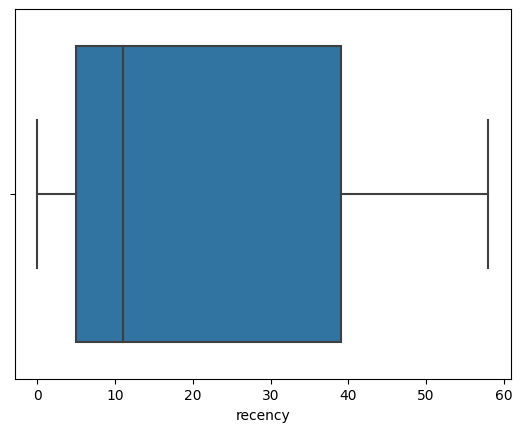

frequency: 


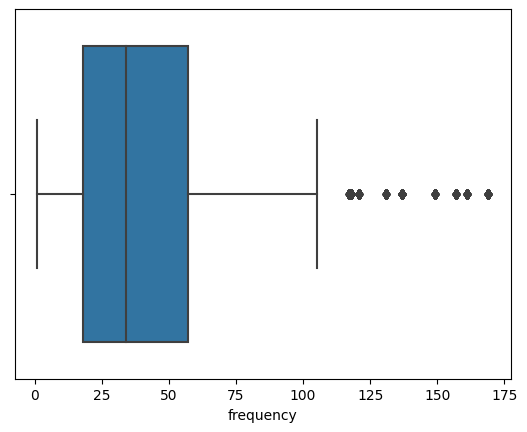

monetary_value: 


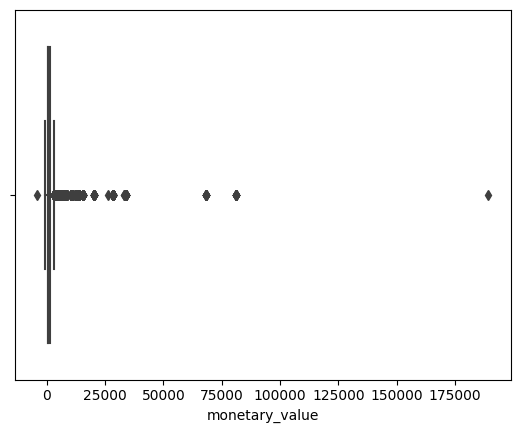

In [11]:
# First need to check the dataframe for outliers and remove them.
# In order to get a visual representation of outliers in the dataframe,
# we create a boxplot of each variable.
list1 = ['recency', 'frequency', 'monetary_value']
for i in list1:
  print(str(i) + ': ')
  ax = sns.boxplot(x = finaldf[str(i)])
  plt.show()

In [12]:
# Recency has no visible outliers, while Frequency and monetary_value
# have many, that must be removed before we start building the model.

from scipy import stats
import numpy as np
# Removing the CustomerID column
new_df = finaldf[['recency', 'frequency', 'monetary_value']]
# Removing outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [13]:
# Now a few extreme values have been removed
new_df.head()

,recency,frequency,monetary_value
1,6,31,1246.73
2,6,31,1246.73
3,6,31,1246.73
4,6,31,1246.73
5,6,31,1246.73


In [14]:
# Standardization
# This is the final pre-processing technique we are gonna apply to the dataset
from sklearn.preprocessing import StandardScaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

In [15]:
# Displaying the dataframe
scaled_features.head()

# The data preparation is done!

,recency,frequency,monetary_value
0,-0.678928,0.570732,0.398575
1,-0.197680,-0.126432,2.871180
2,1.566893,0.819719,2.944136
3,1.246061,-0.176229,-0.411677
4,-0.304624,3.160197,1.906772


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia')

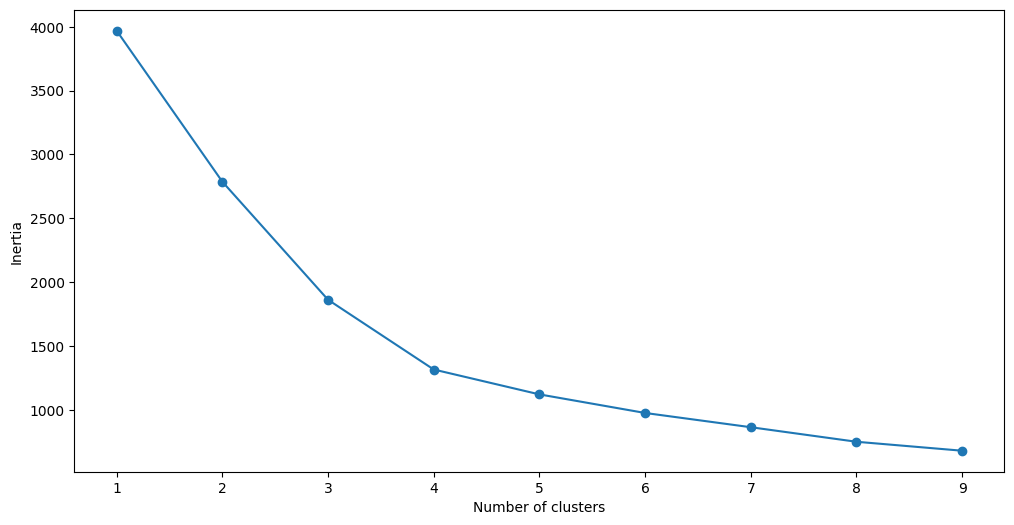

In [22]:
# Building the Customer Segmentation Model

# Creating a K-Means cluestering algorithm to perform the customer segmentation.
# Its goal is to segment all the data available into non-overlapping sub-groups
# that are distinct from each other.

# We're gonna create a loop and run the K-Means algorithm from 1 to 10 clusters.
# Then we'll be able to plot results of this range of values and select the elbow
# of the curve as the number of clusters to use.

# But first we must import all the necessary libraries.
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

SSE = []
for cluster in range(1, 10):
  kmeans = KMeans(n_clusters = cluster, init = 'k-means++')
  kmeans.fit(scaled_features)
  SSE.append(kmeans.inertia_)
# Converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster' : range(1, 10), 'SSE' : SSE})
plt.figure(figsize = (12, 6))
plt.plot(frame['Cluster'], frame['SSE'], marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [26]:
# The elbow of the graph above is the point of inflection on the curve, and in this
# case is at the 4-cluster mark.

# This means that the optimal number of clusters to use in this K-Means algorithm
# is 4. Now we build the model with 4 clusters.

# First we build a model with 4 clusters
kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

# We're gonna use the silhouette score to evaluate the performance of the model.
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

# The silhouette coefficient of this model is 0.51

0.5174103763145355


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
# Segmentation Model Interpretation and Visualization

# Now that the segmentation model is built, we gotta assign the clusters
# to each customer in the dataset

pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

# Displaying the dataframe that we just created
frame.head()

,recency,frequency,monetary_value,cluster
1,6,31,1246.73,0
32,15,17,4311.90,2
49,48,36,4402.34,2
85,42,16,242.30,3
101,13,83,3116.37,1


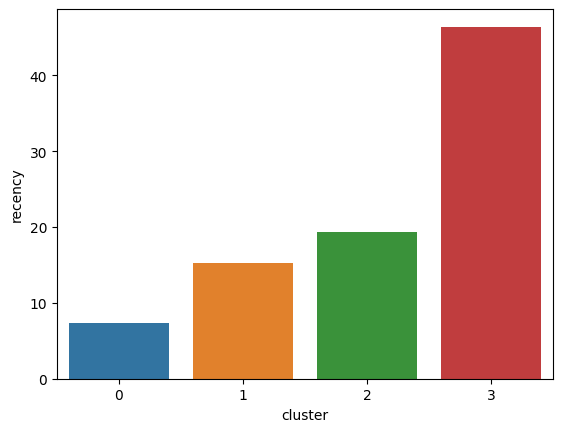

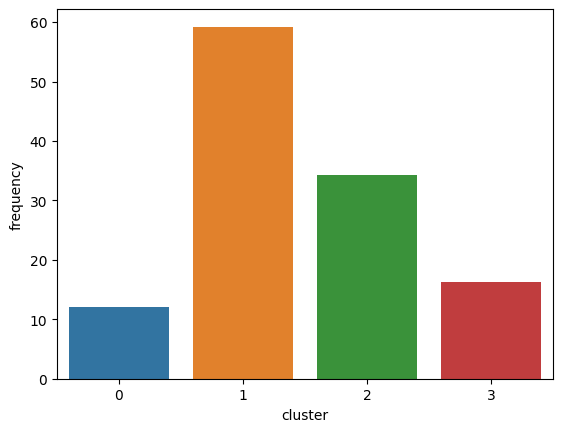

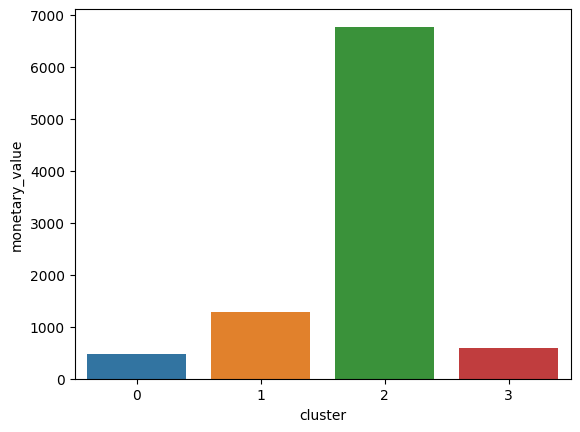

In [32]:
# Visualizing the data to identify the distinct traits of customers
# in each segment

avg_df = frame.groupby(['cluster'], as_index = False).mean()
for i in list1:
  sns.barplot(x = 'cluster', y = str(i), data = avg_df)
  plt.show()